**_Note:_** The table of contents only works while on Jupyter and not when rendered by Github.
## Table of Contents<a class="anchor" id="table_content"></a>
* <a href="#chapter1">1. Google BigQuery on fishing efforts (data from Global Fishing Watch)]</a>
    * <a href="#section_1_1">1.1 Instantiate Google BigQuery object that will perform queries</a>
    * <a href="#section_1_2">1.2 Find total number of vessel that have an associated flag</a>
    * <a href="#section_1_3">1.3 Find what countries had the most accumulated fishing hours overall</a>
    * <a href="#section_1_4">1.4 Find the one gear per country that has the most accumulated fishing hours</a>
* <a href="#chapter2">2 Movement ecology of European Seabass (*Dicentrarchus labrax*) and Graph Theory</a>
    * <a href="#section_2_1">2.1 Generate graph matrix for residency and between-zone transitions</a>
    * <a href="#section_2_2">2.2 Calculate the size of each zone according to its residency</a>
    * <a href="#section_2_3">2.3 Calculate the size of edge for transitions between zones</a>
    * <a href="#section_2_4">2.4 Build and plot the new ecological connectivity graph</a>
* <a href="#chapter3">3 Age-structured Virtual Population Analysis for sprat in the Central Baltic Sea</a> 
    * <a href="#section_3_1">3.1 Read vpa input data</a>
    * <a href="#section_3_2">3.2 Classes and functions needed</a>
    * <a href="#section_3_3">3.3 Calculation of N, F, SSB and R for fixed and variable M</a>
    * <a href="#section_3_4">3.4 S-R relationship and Blim</a>
* <a href="#chapter4">4 Index of abundance and Catchability area for Baltic Sprat in 2003 and 2011 (R and QGIS)</a>
    * <a href="#section_4_1">4.1 Calculate abundances by years and ICES squares</a>
    * <a href="#section_4_2">4.2 Abundances by years and ICES squares as barplots and Venn diagrams</a>
    * <a href="#section_4_3">4.3 Map of hauls and abundances for 2003 and 2001 (QGIS)</a>
* <a href="#chapter5">5 Python and R requirements</a>
    

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import piecewise_regression

from pathlib import Path
from typing import List, Dict
from google.cloud import bigquery
from google.oauth2 import service_account


path = Path(__file__).resolve()
ROOT_PATH = path.parents[2]

# Basic paths to key folders
ENV_PATH = ROOT_PATH / 'env'
REPO_PATH = ROOT_PATH / 'fishery-analysis'
DATA_PATH = REPO_PATH / 'src' / 'data'

# Credential are stored away from the project folder
CREDENTIALS_PATH = str(ENV_PATH / 'google_gfw_credentials.json')

# 1) Google BigQuery on fishing efforts (data from Global Fishing Watch) <a class="anchor" id="chapter1"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

## 1.1) Instantiate Google BigQuery object that will perform queries <a class="anchor" id="section_1_1"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

Data from Global Fishing Watch about vessels' fishing efforts has been downloaded from https://globalfishingwatch.org/data-download/datasets/public-fishing-effort. The ``fishing-vessels-v2.xlsx`` csv file was then processed and uploaded to Google BigQuery. The example here is accessing BigQuery through A REST API.

In [2]:
credentials = service_account.Credentials.from_service_account_file( CREDENTIALS_PATH, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

## 1.2) Find total number of vessel that have an associated flag <a class="anchor" id="section_1_2"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

Flags `flag_gfw`, `flag_registry` and `flag_ais` are used to identified what flag is associated to a vessel. The next query pulls which flag identified the most vessels as percentage of all existing records.

In [3]:
table = "gfw-testing-377510.fishing_efforts.fishing_data"
query = f"""
SELECT
  CONCAT(FORMAT ("%'.2f", SUM(CASE
          WHEN flag_gfw IS NOT NULL THEN 1
        ELSE
        0
      END
        ) / COUNT(*) * 100), '%') AS num_flag_gfw,
  CONCAT(FORMAT ("%'.2f", SUM(CASE
          WHEN flag_ais IS NOT NULL THEN 1
        ELSE
        0
      END
        ) / COUNT(*) * 100), '%') AS num_flag_ais,
  CONCAT(FORMAT ("%'.2f", SUM(CASE
          WHEN flag_registry IS NOT NULL THEN 1
        ELSE
        0
      END
        ) / COUNT(*) * 100), '%') AS num_flag_registry
FROM
  {table}
  """
query_job = client.query(query)

In [4]:
query_job.to_dataframe()

,num_flag_gfw,num_flag_ais,num_flag_registry
0,99.22%,79.79%,21.59%


## 1.3) Find what countries had the most accumulated fishing hours overall <a class="anchor" id="section_1_3"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>


TNext query obtains the list of countries, fishing gear and total fishing hours per country and gear. All gears for all countries are fetched but the results are sorted by the total fishing hours per gear in descending order. We use ``flag_gfw`` as it was the flag that identified the most vessels. 

For example, tandem (Spain, drifting long lines) appears on the 4th place and (Spain, trawlers) on 7th.


In [5]:
query = f"""
SELECT
  flag_gfw,
  vessel_class_gfw,
  SUM(fishing_hours_2012 + fishing_hours_2013 + fishing_hours_2014 + fishing_hours_2015 + fishing_hours_2016 + fishing_hours_2017 + fishing_hours_2018 + fishing_hours_2019 + fishing_hours_2020) AS total_fishing_hours
FROM
  {table}
WHERE
  flag_gfw IS NOT NULL
  AND vessel_class_gfw IS NOT NULL
GROUP BY
  flag_gfw,
  vessel_class_gfw
HAVING
  total_fishing_hours IS NOT NULL
ORDER BY
  total_fishing_hours DESC,
  flag_gfw
"""
query_job = client.query(query)

In [6]:
query_job.to_dataframe().head(15)

,flag_gfw,vessel_class_gfw,total_fishing_hours
0,FRA,trawlers,6323317.82
1,RUS,trawlers,5230893.76
2,KOR,drifting_longlines,4225950.01
3,CHN,trawlers,3085546.93
4,ESP,drifting_longlines,3071283.75
5,JPN,drifting_longlines,2822906.47
6,ITA,trawlers,2491535.95
7,ESP,trawlers,2412337.95
8,NLD,trawlers,2299255.37
9,DNK,trawlers,2156840.78


## 1.4) Find the one gear per country that has the most accumulated fishing hours <a class="anchor" id="section_1_4"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>


Contrary to the the earlier query, the next one will find the one gear per country with most accummulated fishing hours over the period 2012-2020. No country is therefore repeated in the list. The resulting list is sorted by the number of fishing hours in descending order. 

To avoid performance issues a **group-wise max query** has been used instead of subqueries.


In [7]:
most_fishing_hours_query = f"""
SELECT
    flag_gfw,
    vessel_class_gfw,
    SUM(fishing_hours_2012 + fishing_hours_2013 + fishing_hours_2014 + fishing_hours_2015 + fishing_hours_2016 + fishing_hours_2017 + fishing_hours_2018 + fishing_hours_2019 + fishing_hours_2020) AS total_fishing_hours
  FROM
    {table}
  WHERE
    flag_gfw IS NOT NULL
    AND vessel_class_gfw IS NOT NULL
  GROUP BY
    flag_gfw,
    vessel_class_gfw
  HAVING
    total_fishing_hours IS NOT NULL
"""

query = f"""
SELECT
  q1.flag_gfw,
  q1.vessel_class_gfw,
  FORMAT("%'.2f", q1.total_fishing_hours) as total_fishing_hours
  -- first query calculating most fishing hours per gear and country
FROM ({most_fishing_hours_query}) q1
LEFT JOIN (
    -- second query calculating most fishing hours per gear and country
  {most_fishing_hours_query}) q2
  -- together with left join, for cases where the 'on' condition does not fully apply, q1 results will still be added, however with is counterpart q2 results set as null ...
ON
  q1.flag_gfw = q2.flag_gfw
  AND q1.total_fishing_hours < q2.total_fishing_hours
WHERE
  q2.flag_gfw IS NULL -- ... and the the records with the q2 null values associated are the largest q1 values
ORDER BY
  q1.total_fishing_hours desc,
  q1.flag_gfw
"""
query_job = client.query(query)

In [8]:
results = query_job.to_dataframe()
results.head(len(results))

,flag_gfw,vessel_class_gfw,total_fishing_hours
0,FRA,trawlers,"6,323,317.82"
1,RUS,trawlers,"5,230,893.76"
2,KOR,drifting_longlines,"4,225,950.01"
3,CHN,trawlers,"3,085,546.93"
4,ESP,drifting_longlines,"3,071,283.75"
5,JPN,drifting_longlines,"2,822,906.47"
6,ITA,trawlers,"2,491,535.95"
7,NLD,trawlers,"2,299,255.37"
8,DNK,trawlers,"2,156,840.78"
9,ARG,trawlers,"1,855,625.76"


# 2) Movement ecology of European Seabass (*Dicentrarchus labrax*) and Graph Theory <a class="anchor" id="chapter2"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

The section below analyses the movement of the Euopean Seabass (*Dicentrarchus labrax*) through a network of Marine Protected Areas (MPAs) in the Northwestern Mediterranean, between the French and Spanish border.

The data was collected by using different techniches of passive acoustic telemetry between late 2020 and early 2022. The resulting graph shows the potential ecological connectivity among the MPAs, specially between Medes Islands and Badia de Roses. Such connection is specially strong because the ontogonetic migration for spawning purpsoes from the rocky shores of Medes islands to the sandy bottoms of the bay. 

The results yield the following information:
* **Residency**: movements that happened within zone (through all hydrophones that are deployed within a single zone)

* **Transitioning**: movements that occurred between two different zones - the origin was an hydrophone from a zone different to its destiantion

In [9]:
# Allows the use of R by using '%%R' within each R-intended cell 
%load_ext rpy2.ipython

In [10]:
%%R
source("R/config.R")
source ("R/utils.R")

# Read data and prepare matrix of detections
locs = prepare_gis_receiver_locations(receiver_loc_path, coast)
data <- read.csv(lubina_detection_path)
data <- data %>% mutate(station=ifelse(station == "",  station_folder, station))

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Linking to GEOS 3.10.2, GDAL 3.4.2, PROJ 8.2.1; sf_use_s2() is TRUE

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:igraph’:

    crossing


R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine


R[writ

Reading layer `coast_cat_fr' from data source 
  `/Users/dgg/Documents/repos/fishery-analysis/src/data/gis_data/coast/coast_cat_fr.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 7 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 482744.5 ymin: 4639662 xmax: 526428.2 ymax: 4717745
Projected CRS: WGS 84 / UTM zone 31N
Reading layer `coast_cat_fr_rivers_3' from data source 
  `/Users/dgg/Documents/repos/fishery-analysis/src/data/gis_data/coast/coast_cat_fr_rivers_3.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 2 fields
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: 2.791046 ymin: 41.98358 xmax: 3.194144 ymax: 42.20165
Geodetic CRS:  WGS 84
Reading layer `coast_cat_fr_port_3' from data source 
  `/Users/dgg/Documents/repos/fishery-analysis/src/data/gis_data/coast/coast_cat_fr_port_3.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 2 fields
Geome

## 2.1) Generate graph matrix for residency and transitioning<a class="anchor" id="section_2_1"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [11]:
%%R
# Generate a graph matrix that contains all loops movement where each node will contain the total movements within zone in %.
only_loops_g <- build_graph_matrix(
  data,
  loop_or_transition = TRUE,
  keep_duplicated_edges = TRUE,
  keep_columns = c('ind_name', 'date_time')
) %>%
  select(from, ind_name, date_time) %>%
  rename(station = from) %>%
  mutate(zone = case_when(
    grepl("M", station, fixed = TRUE) ~ 'M',
    grepl("G", station, fixed = TRUE) ~ 'G',
    grepl("C", station, fixed = TRUE) ~ 'C',
    grepl("B", station, fixed = TRUE) ~ 'B',
  )) %>%
  group_by(zone) %>%
  summarise(detections = n()) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))

only_loops_g  # Medes Islands accumulates 82.3 of all movements

# A tibble: 4 × 4
  zone  detections percentage   cum
  <chr>      <int>      <dbl> <dbl>
1 M         146388      82.3   82.3
2 G          17240       9.69  92.0
3 C          11402       6.41  98.4
4 B           2897       1.63 100  


In [12]:
%%R

# Generate a graph matrix that contains all transition movements where movements between nodes are calculated as a percentange of the total.
no_loops_g <- build_graph_matrix(
  data,
  loop_or_transition = FALSE,
  keep_duplicated_edges = TRUE,
  keep_columns = c('ind_name', 'date_time')
) %>%
  select(from, to, ind_name, date_time) %>%
  mutate(
    zone_interaction = case_when(
      # Medes
      grepl("M", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-M',
      grepl("M", from, fixed = TRUE) &
        grepl("G", to, fixed = TRUE) ~ 'M-G',
      grepl("G", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-G',
      grepl("M", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'M-C',
      grepl("C", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-C',
      grepl("M", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'M-B',
      grepl("B", from, fixed = TRUE) &
        grepl("M", to, fixed = TRUE) ~ 'M-B',

      # G
      grepl("G", from, fixed = TRUE) &
        grepl("G", to, fixed = TRUE) ~ 'G-G',
      grepl("G", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'G-C',
      grepl("C", from, fixed = TRUE) &
        grepl("G", to, fixed = TRUE) ~ 'G-C',
      grepl("G", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'G-B',
      grepl("B", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'G-B',

      # C
      grepl("C", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'C-C',
      grepl("C", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'C-B',
      grepl("B", from, fixed = TRUE) &
        grepl("C", to, fixed = TRUE) ~ 'C-B',

      # B
      grepl("B", from, fixed = TRUE) &
        grepl("B", to, fixed = TRUE) ~ 'B-B'
    )
  ) %>%
  group_by(zone_interaction) %>%
  summarise(detections = n()) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))
no_loops_g # The interactions beween

# A tibble: 10 × 4
   zone_interaction detections percentage   cum
   <chr>                 <int>      <dbl> <dbl>
 1 M-M                  177940      56.9   56.9
 2 M-G                   72279      23.1   80.0
 3 M-C                   36334      11.6   91.7
 4 G-G                   14116       4.52  96.2
 5 G-C                    6318       2.02  98.2
 6 M-B                    4203       1.34  99.6
 7 C-C                     923       0.3   99.8
 8 C-B                     418       0.13 100. 
 9 G-B                      16       0.01 100. 
10 <NA>                     15       0    100. 


## 2.2) Calculate the size of each zone according to its residency <a class="anchor" id="section_2_2"></a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [13]:
%%R

# --> get node size % for loops and within station movements
node_size_df <- no_loops_g %>%
  filter(
    if_any(zone_interaction, ~str_detect(., "M-M")) |
      if_any(zone_interaction, ~str_detect(., "G-G")) |
      if_any(zone_interaction, ~str_detect(., "C-C")) |
      if_any(zone_interaction, ~str_detect(., "B-B"))
  ) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "M-M", "M")) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "G-G", "G")) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "C-C", "C")) %>%
  mutate(zone_interaction = str_replace(zone_interaction, "B-B", "B")) %>%
  select(zone_interaction, detections) %>%
  rename(zone = zone_interaction)

node_size_df[nrow(node_size_df) + 1,] = list("B", 1)

# Merge loops and within movements
zone_loops <- only_loops_g %>% select(zone, detections)
node_size_df <- merge(node_size_df, zone_loops, all = TRUE)

# Calculate % in the dataframe
node_size_df <- node_size_df %>%
  group_by(zone) %>%
  summarise(detections = sum(detections)) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))


## 2.3) Calculate the size of edge for transitions between zones<a class="anchor" id="section_2_3"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [14]:
%%R
# Build edge size
# --> get % edges weight
edge_weight_df <- no_loops_g %>%
  filter(
    !if_any(zone_interaction, ~str_detect(., "M-M")) &
    !if_any(zone_interaction, ~str_detect(., "G-G")) &
    !if_any(zone_interaction, ~str_detect(., "C-C")) &
    !if_any(zone_interaction, ~str_detect(., "B-B"))
  ) %>%
  select(zone_interaction, detections) %>%
  rename(zone = zone_interaction) %>%
  group_by(zone) %>%
  summarise(detections = sum(detections)) %>%
  mutate(percentage = round((detections / sum(detections)) * 100, 2)) %>%
  arrange(desc(percentage)) %>%
  mutate(cum = cumsum(percentage))

## 2.4) Build and plot the new ecological connectivity graph <a class="anchor" id="section_2_4"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [15]:
%%R
# Build Graph
# --> Get coordinates of representative marine reserves
zone_stations <- locs %>%
  filter(station == 'M08' |
         station == 'G06' |
         station == 'C18' |
         station == 'B17') %>%
  mutate(station = str_replace(station, "M08", "M")) %>%
  mutate(station = str_replace(station, "G06", "G")) %>%
  mutate(station = str_replace(station, "C18", "C")) %>%
  mutate(station = str_replace(station, "B17", "B"))
    
# Assign node sizes and edge weights
# --> Create the mobility graph between zones in the same exact order as the
# descending edge weight order
zone_graph <- make_undirected_graph(c("M", "G", "M", "C", "G", "C",
                                      "M", "B", "C", "B", "G", "B"))

# --> Get coordinates of graph and bounding box
coords_simple_g <-
  get_graph_coordinates(zone_graph, zone_stations)
bb_simple_g <-
  adjust_coord_bb(coords_simple_g, min_half_size = 2000)
bb_simple_g$ymin[1] <- bb_simple_g$ymin[1] - 2000


# --> Resize and rename nodes and "reweight" the transition edges
V(zone_graph)$size <- node_size_df$percentage
V(zone_graph)$name <- c("Illes Medes", "Badia de Roses", "Cap de Creus", "Banyuls")
E(zone_graph)$weight <- edge_weight_df$percentage

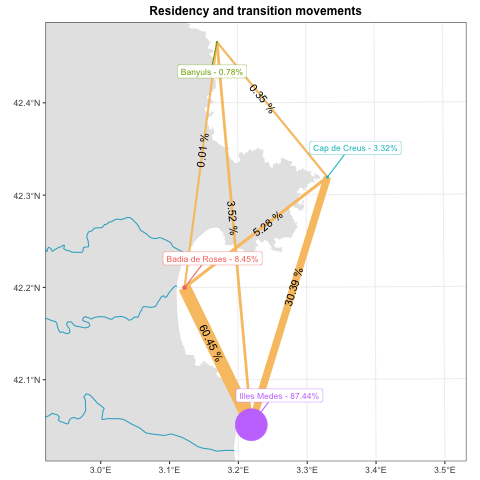

In [16]:
%%R
# Draw finally the graph
river_color = "#38afcd"
edge_color = "#F8C471"
plot_title = "Residency and transition movements"
zone_graph_plot <- ggraph(zone_graph,
                          layout = "manual",
                          x = coords_simple_g$X,
                          y = coords_simple_g$Y) +

  ggtitle(plot_title) +
  geom_sf(data = coast, col = NA) +
  geom_sf(data = river, col = river_color) +
  geom_sf(data = river_muga, col = river_color) +
  geom_sf(data = port, col = "black") +


  coord_sf(
    xlim = c(bb_simple_g$xmin, bb_simple_g$xmax),
    ylim = c(bb_simple_g$ymin, bb_simple_g$ymax)
  ) +

  geom_edge_link(
    color = edge_color,
    aes(
      width = E(zone_graph)$weight / 5,
      label = paste(E(zone_graph)$weight, "%")
    ),
    angle_calc = "along",
    label_push = unit(5, "mm")
  ) +

  # Node settings
  # --> We need a legend
  geom_node_point(aes(colour = V(zone_graph)$name),
                  size = V(zone_graph)$size / 6) +

  geom_node_label(
    aes(
      colour = V(zone_graph)$name,
      label = paste0(V(zone_graph)$name,
                     " - ",
                     V(zone_graph)$size,
                     "%")
    ),
    label.size = 0.15,
    size = 3,
    nudge_x = 4,
    nudge_y = -3,
    repel = TRUE,
    max.overlaps = Inf,
    box.padding = unit(1.5, "lines")
  ) +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 12, hjust = 0.5, face = "bold")
  ) +
  xlab(NULL) +
  ylab(NULL)
    
zone_graph_plot


# 3) Age-structured Virtual Population Analysis <a class="anchor" id="chapter3"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

This section shows a classical example of Age-structured Virtual Population Analysis (VPA) for the sprat stock (*Sprattus sprattus*) in the Central Baltic Sea. The fishery-independent data was collected through scientific surveys conducted in the period 1984-2013.

The exercixe has the following objectives:

* **Show the impacts for fixed and variable M on F, SSB and R**, as provided from a single-species and multiple-species stock assessment model.

* **Show the S-R relationship and calculate the B<sub>lim</sub> for the stock**. The stock is thought to have impaired recruitment years so the stock type is thought to be of type 2, according to ICES classification here: https://ices-library.figshare.com/articles/report/Technical_Guidelines_-_ICES_fisheries_management_reference_points_for_category_1_and_2_stocks_2021_/18638150

* **A piece-regression algorithm is used in order to see whether the stock is of type 2**. No plateu is found hence Type 2 strictly was discarded

The final conclusion is that **B<sub>lim</sub>** may be around **1,000 tonnes**.


## 3.1 Read vpa input data <a class="anchor" id="section_3_1"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [17]:
# Read catch, and mortality rates (1)
# ---> read weight at age
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'weight_age.csv')
w = pd.read_csv(data_path)

# ---> read weight at age SD25
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'weight_age_25.csv')
w25 = pd.read_csv(data_path)

# ---> read weight at age
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'maturity_rate.csv')
mat = pd.read_csv(data_path)

# ---> read fixed natural mortality matrix
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'm_mortality_rate.csv')
m = pd.read_csv(data_path)

# ---> read variable natural mortality matrix
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'vm_mortality_rate.csv')
vm = pd.read_csv(data_path)

# ---> read fishing mortality matrix
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'f_mortality_rate.csv')
f = pd.read_csv(data_path)

# --> read catch matrix
data_path =os.path.join(DATA_PATH, 'vpa', 'inputs', 'catch_rate.csv')
c = pd.read_csv(data_path)

# --> abundance matrix
n = f.copy()
n[n.columns[1:]] = 0

# --> Year pandas series
year_series = c.year

In [18]:
vm

,year,1,2,3,4,5,6,7,8
0,1984,0.63,0.63,0.63,0.61,0.59,0.58,0.58,0.58
1,1985,0.54,0.54,0.53,0.52,0.51,0.50,0.50,0.50
2,1986,0.47,0.47,0.47,0.46,0.45,0.45,0.44,0.44
3,1987,0.43,0.43,0.43,0.42,0.41,0.40,0.40,0.40
4,1988,0.43,0.43,0.43,0.42,0.41,0.41,0.41,0.41
5,1989,0.39,0.39,0.39,0.38,0.38,0.37,0.37,0.37
6,1990,0.33,0.33,0.33,0.32,0.32,0.32,0.32,0.32
7,1991,0.28,0.28,0.28,0.28,0.28,0.27,0.27,0.27
8,1992,0.27,0.27,0.27,0.27,0.26,0.26,0.26,0.26
9,1993,0.30,0.30,0.30,0.29,0.29,0.29,0.29,0.29


## 3.2 Classes and functions needed <a class="anchor" id="section_3_2"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [19]:
class Abundance:
    
    def __init__ (self, c: pd.DataFrame, m: pd.DataFrame, f: pd.DataFrame):
        self.c = c
        self.m = m
        self.f = f
    
    def calculate_abundance_last_cols_rows (self) -> pd.DataFrame:
        n = self.f.copy()
        n[n.columns[1:]] = 0
        
        # Calculate abundance for last column (age 8 for all years)
        ct = self.c.iloc[:, -1]
        zt = self.f.iloc[:, -1] + self.m.iloc[:, -1]
        ft = self.f.iloc[:, -1]
        exp_z = 1 - np.exp(-zt)
        #----> update last column
        n.iloc[:, -1] = round((ct * zt) / (ft * exp_z), 2)

        # Calculate abundance for last row (all ages for the last year)
        ct = self.c.iloc[-1, 1:].reset_index(drop=True)
        zt = (self.f.iloc[-1, 1:] + self.m.iloc[-1, 1:]).reset_index(drop=True)
        ft = self.f.iloc[-1, 1:].reset_index(drop=True)
        exp_z = 1 - np.exp(-zt)
        #----> update last rowex
        n.iloc[-1, 1:] = round((ct * zt) / (ft * exp_z), 2)
        return n
    
    def calculate_abundance_rest_cols_rows (self, n: pd.DataFrame) -> pd.DataFrame:
        for col in range(len(n.columns)-1, 1, -1): # Calculation from age 7 to age 1
            nt1 = n.iloc[1:, col].reset_index(drop=True) # Nt+1,a+1
            e_m = np.exp(self.m.iloc[:-1, col-1])
            em_2 = np.exp(self.m.iloc[:-1, col-1] / 2)
            ct = self.c.iloc[:-1, col-1]
            n.iloc[:-1, col-1] = round((nt1 * e_m) + (ct * em_2), 2)
        return n
    
    def calculate (self) -> pd.DataFrame:
        n = self.calculate_abundance_last_cols_rows()
        n = self.calculate_abundance_rest_cols_rows(n)
        return (n)
    

In [20]:
class FishingMortality:
    
    def __init__(self, n: pd.DataFrame, m: pd.DataFrame, f: pd.DataFrame):
        self.n = n
        self.m = m
        self.f = f.copy()
    
    def calculate_all_but_last_row(self) -> pd.DataFrame:
        for col in range(len(self.n.columns)-1, 1, -1): # from age 8 to age 2 but calucations are from age 7 to 1
            nta1 = self.n.iloc[1:, col].reset_index(drop=True) # Nt+1,a+1
            nta = self.n.iloc[:-1, col-1]
            log_n = np.log(nta / nta1)
            mt = self.m.iloc[:-1, col-1]  # mt = M
            self.f.iloc[:-1, col-1] = round(log_n - mt, 2)
        return self.f
        
    def calculate_average_last_row(self, from_col: int, to_col: int):
        f_average = ((self.f.iloc[:-1, from_col:to_col]).mean(axis=1)).values
        self.f.iloc[:-1, -1] = f_average
        return self.f
    
    def calculate(self, from_col: int, to_col: int):
        self.calculate_all_but_last_row()
        self.calculate_average_last_row(from_col, to_col)
        return self.f
    

In [21]:
def calculate_N_and_F (iteration: int, c: pd.DataFrame, m: pd.DataFrame, f: pd.DataFrame):
    for _ in range(iteration):
        abundance = Abundance(c, m, f)
        n = abundance.calculate()
        fishing_mortality = FishingMortality(n, m, f)
        from_col, to_col = 3, 8
        f = fishing_mortality.calculate(from_col, to_col)
    return (n, f)

def build_twin_lineplot_legend(data: List[Dict]):
    return ([mlines.Line2D([], [], color=x['color'], label=x['label']) for x in data])

## 3.3 Calculation of N, F, SSB and R for fixed and variable M <a class="anchor" id="section_3_3"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [22]:
cal_num_iterations = 6
# Calculate N and F with fixed mortality
n, new_f = calculate_N_and_F (cal_num_iterations, c, m, f)

# Calculate N and F with variable mortality
n_vm, new_f_vm = calculate_N_and_F (cal_num_iterations, c, vm, f)

In [23]:
n_vm

,year,1,2,3,4,5,6,7,8
0,1984,83637.99,92051.44,21530.48,16004.77,3952.46,2936.97,3592.55,4607.25
1,1985,54330.82,43811.47,47279.46,11183.80,8366.71,2133.63,1615.97,2004.73
2,1986,41741.12,31229.12,24231.02,25894.80,6304.34,4814.17,1270.75,965.34
3,1987,38012.42,25696.96,18615.44,14017.88,14679.24,3748.33,2919.53,805.57
4,1988,26328.96,24099.13,16398.33,11044.88,7724.60,8271.44,2326.73,1835.03
5,1989,49656.18,17064.32,13502.27,10078.49,6325.64,4505.67,4870.21,1491.18
6,1990,50977.86,31890.46,11314.89,7683.74,6558.20,3714.74,2788.09,3033.24
7,1991,64198.81,35759.75,20238.14,7841.17,4768.30,4602.03,2428.18,1929.13
8,1992,102851.27,47612.81,24723.71,13175.29,5572.40,3109.14,3420.48,1713.83
9,1993,118460.50,76957.59,33778.79,16217.48,8622.23,3906.73,2124.22,2531.12


In [24]:
# Calculate ssb, rs and fm with fixed M
ssb = f.copy()
ssb[ssb.columns[1:]] = 0
ssb.iloc[:, 1:] = w.iloc[:, 1:] * mat.iloc[:, 1:] * n.iloc[:, 1:]
fm_rs_ssb = pd.DataFrame(data={'year': year_series, 
                               'ssb': ssb.iloc[:, 1:].sum(axis=1), 
                               'rs': n.iloc[:, 1],
                               'fm': new_f.iloc[:, 3:6].mean(axis=1).values}) # note that to compute the fishing mortality we only take into account ages from 3 to 6

# Calculate ssb, rs and fm with variable M
ssb_vm = f.copy()
ssb_vm[ssb.columns[1:]] = 0
ssb_vm.iloc[:, 1:] = w.iloc[:, 1:] * mat.iloc[:, 1:] * n_vm.iloc[:, 1:]
fm_rs_ssb_vm = pd.DataFrame(data={'year': year_series, 
                               'ssb': ssb_vm.iloc[:, 1:].sum(axis=1), 
                               'rs': n_vm.iloc[:, 1],
                               'fm': new_f_vm.iloc[:, 3:6].mean(axis=1).values}) # note that to compute the fishing mortality we only take into account ages from 3 to 6


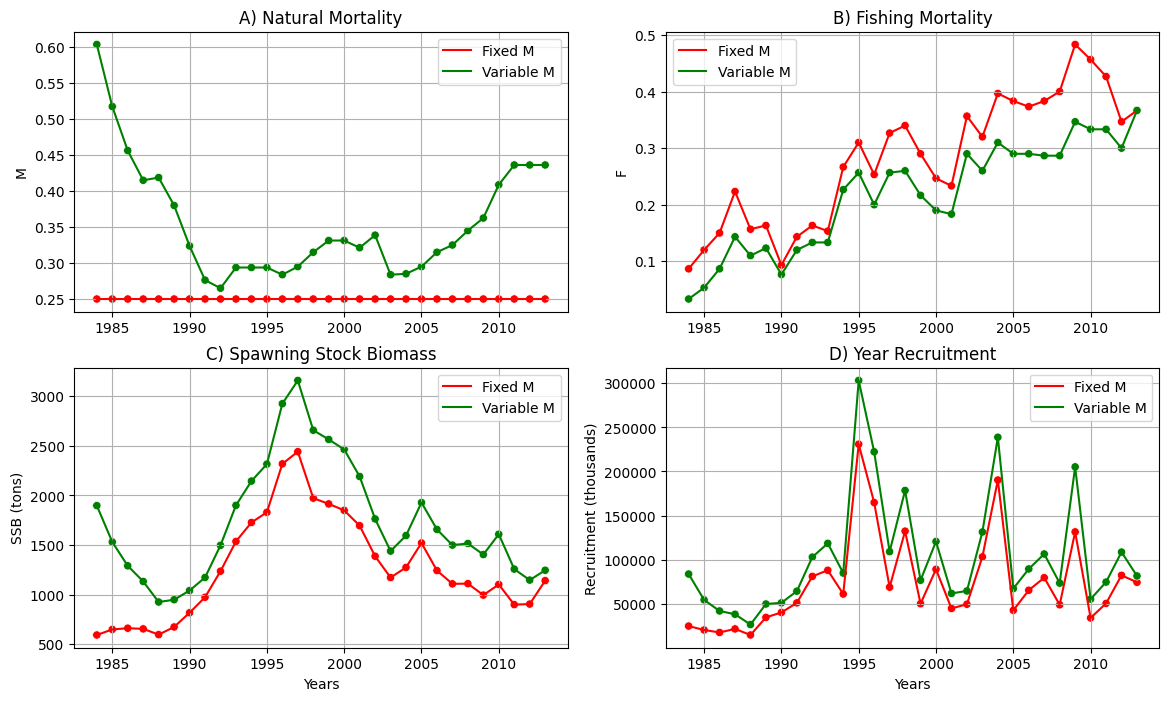

In [25]:
# Plot all M, F, SSB and R 
_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,8))

# 1) Natural mortality comparison when M fixed vs variable
mf_vs_mv = pd.DataFrame(data={'year': year_series, 'm': m.iloc[:, 1:].mean(axis=1), 'm_type': 'Fixed M'})
mvar = pd.DataFrame(data={'year': year_series, 'm': vm.iloc[:, 1:].mean(axis=1), 'm_type': 'Variable M'})
mf_vs_mv = pd.concat([mf_vs_mv, mvar], axis=0, keys=['m', 'm']).reset_index()

sns.scatterplot(data=mf_vs_mv, 
                x = "year", 
                y="m",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[0][0]).set(title = "A) Natural Mortality")
sns.lineplot(data=mf_vs_mv, x='year', y='m', hue='m_type', palette=['r', 'g'], ax = ax[0][0])
ax[0][0].legend(title= "M (variable vs fixed)")

# 2) Fishing mortality comparison when M fixed vs variable
ff_vs_fv = pd.DataFrame(data={'year': year_series, 'fm': fm_rs_ssb.fm, 'm_type': 'Fixed M'})
fv = pd.DataFrame(data={'year': year_series, 'fm': fm_rs_ssb_vm.fm, 'm_type': 'Variable M'})
ff_vs_fv = pd.concat([ff_vs_fv, fv], axis=0, keys=['fm', 'fm']).reset_index()

sns.scatterplot(data=ff_vs_fv, 
                x = "year", 
                y="fm",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[0][1]).set(title = "B) Fishing Mortality")
sns.lineplot(data=ff_vs_fv, x='year', y='fm', hue='m_type', palette=['r', 'g'], ax = ax[0][1])
ax[0][1].legend(title= "F (variable vs fixed)")


# 3) SSB comparison when M fixed vs variable
ssbf_vs_ssbv = pd.DataFrame(data={'year': year_series, 'ssb': fm_rs_ssb.ssb, 'm_type': 'Fixed M'})
ssbv = pd.DataFrame(data={'year': year_series, 'ssb': fm_rs_ssb_vm.ssb, 'm_type': 'Variable M'})
ssbf_vs_ssbv = pd.concat([ssbf_vs_ssbv, ssbv], axis=0, keys=['ssb', 'ssb']).reset_index()

sns.scatterplot(data=ssbf_vs_ssbv,
                x = "year",
                y="ssb",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[1][0]).set(title = "C) Spawning Stock Biomass")
sns.lineplot(data=ssbf_vs_ssbv, x='year', y='ssb', hue='m_type', palette=['r', 'g'], ax = ax[1][0])
ax[1][0].legend(title= "SSB (variable vs fixed)")

# 4) Year Recruitment comparison when M fixed vs variable
rsf_vs_rsbv = pd.DataFrame(data={'year': year_series, 'rs': fm_rs_ssb.rs, 'm_type': 'Fixed M'})
rsv = pd.DataFrame(data={'year': year_series, 'rs': fm_rs_ssb_vm.rs, 'm_type': 'Variable M'})
rsf_vs_rsbv = pd.concat([rsf_vs_rsbv, rsv], axis=0, keys=['rs', 'rs']).reset_index()

sns.scatterplot(data=rsf_vs_rsbv,
                x = "year",
                y="rs",
                hue='m_type',
                palette=['r', 'g'], 
                ax = ax[1][1]).set(title = "D) Year Recruitment")
sns.lineplot(data=rsf_vs_rsbv, x='year', y='rs', hue='m_type', palette=['r', 'g'], ax = ax[1][1])
ax[1][1].legend(title= "SSB (variable vs fixed)")
ax[1][1].legend(title= "Recruitment (variable vs fixed)")

ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[1][0].set_xlabel('Years')
ax[1][1].set_xlabel('Years')

ax[0][0].set_ylabel('M')
ax[0][1].set_ylabel('F')
ax[1][0].set_ylabel('SSB (tons)')
ax[1][1].set_ylabel('Recruitment (thousands)')


# Remove dots legend
for i in range(2):
    for j in range(2):
        handles, labels = ax[i][j].get_legend_handles_labels()
        ax[i][j].legend(handles[2:], labels)
        ax[i][j].grid()


## 3.4 S-R relationship and Blim <a class="anchor" id="section_3_4"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [26]:
# Amalgamate SSBs calculated with fixed and variable M
ssb_m = fm_rs_ssb.ssb
ssb_vm = fm_rs_ssb_vm.ssb
ssbs = pd.DataFrame(data={'ssbm': ssb_m, 'ssbvm': ssb_vm})
ssbs.describe()

,ssbm,ssbvm
count,30.000000,30.000000
mean,1267.513920,1727.605112
std,515.227629,592.539813
min,594.485985,926.593838
25%,901.815292,1266.548518
50%,1157.530032,1563.435572
75%,1655.724580,2090.649046
max,2440.751801,3158.113373


In [27]:
# Amalgamate Rs calculated with fixed and variable M
rs_m = fm_rs_ssb.rs
rs_vm = fm_rs_ssb_vm.rs
rss = pd.DataFrame(data={'rsm': rs_m, 'rsvm': rs_vm,})
rss.describe()

,rsm,rsvm
count,30.000000,30.000000
mean,72816.412667,102755.373333
std,52095.041062,65434.077698
min,14479.460000,26328.960000
25%,40650.117500,62284.450000
50%,55932.365000,82550.570000
75%,86494.380000,116096.367500
max,230957.680000,303269.150000


In [41]:
pw_fit = piecewise_regression.Fit(ssb_m.values, rs_m.values, n_breakpoints=2)

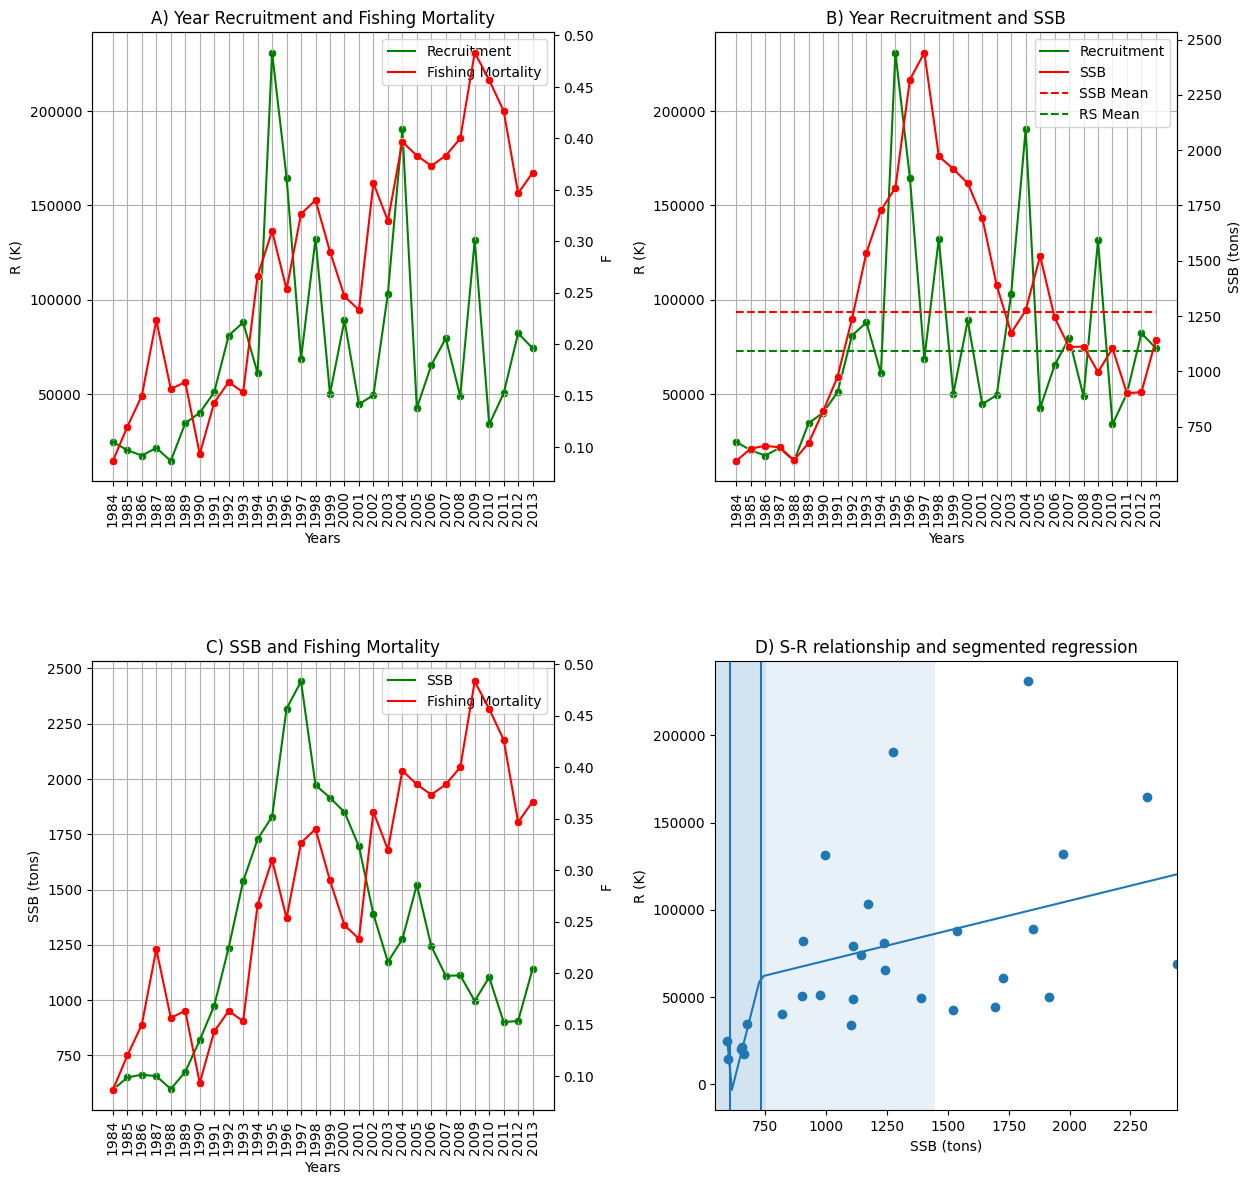

In [42]:
# Plot S-R relationship and the different input relationships

_, ax =plt.subplots(nrows=2, ncols=2, figsize=(14,14))

# # Plot segementation regrestion
pw_fit.plot()
ax[1][1].set_title("D) S-R relationship and segmented regression")
ax[1][1].set_xlabel("SSB (tons)")
ax[1][1].set_ylabel("R (K)")
ax[1][1].set_xlim(min(ssb_m.values) - 50,max(ssb_m.values))

# Plot Year class recruitment and fishing mortality
ax_00 = ax[0][0].twinx()
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="rs", 
                color='g',
                ax = ax[0][0])
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='rs', 
             color='g',
             ax = ax[0][0])
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="fm",
                color='r',
                ax = ax_00)
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='fm', 
             color='r', 
             ax = ax_00)
ax_00.set_ylabel("F")
ax[0][0].set(xticks=year_series)
ax[0][0].set_xticklabels(ax[0][0].get_xticks(), rotation = 90)
ax[0][0].set_title("A) Year Recruitment and Fishing Mortality")
ax[0][0].set_xlabel("Years")
ax[0][0].set_ylabel("R (K)")
handles = build_twin_lineplot_legend ([{'color': 'g', 'label': 'Recruitment'}, 
                             {'color': 'r', 'label': 'Fishing Mortality'}])
ax[0][0].legend(handles = handles)
ax[0][0].grid()


# Plot Year class recruitment and SSB
ax_01 =ax[0][1].twinx()

sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="rs", 
                 color='g',
                ax = ax[0][1])
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='rs', 
             color='g',
             ax = ax[0][1])
sns.lineplot(x=year_series, 
             y=[fm_rs_ssb.rs.mean()] * len(year_series), 
             color='g',
             linestyle='--',
             ax = ax[0][1])
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="ssb",
                color='r',
                ax = ax_01)
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='ssb', 
             color='r', 
             ax = ax_01)
sns.lineplot(x=year_series, 
             y=[fm_rs_ssb.ssb.mean()] * len(year_series), 
             color='r',
             linestyle='--',
             ax = ax_01)
ax_01.set_ylabel("SSB (tons)")
ax[0][1].set(xticks=year_series)
ax[0][1].set_xticklabels(ax[0][0].get_xticks(), rotation = 90)
ax[0][1].set_title("B) Year Recruitment and SSB")
ax[0][1].set_xlabel("Years")
ax[0][1].set_ylabel("R (K)")
handles = build_twin_lineplot_legend ([{'color': 'g', 'label': 'Recruitment'}, 
                             {'color': 'r', 'label': 'SSB'}])
handles.extend([mlines.Line2D([], [], color='r', label='SSB Mean', linestyle='--'), 
               mlines.Line2D([], [], color='g', label='RS Mean', linestyle='--')])
ax[0][1].legend(handles = handles)
ax[0][1].grid()


# Plot SSB and mortality recruitment
ax_10 =ax[1][0].twinx()
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="ssb", 
                color='g',
                ax = ax[1][0])
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='ssb', 
             color='g',
             ax = ax[1][0])
sns.scatterplot(data=fm_rs_ssb,
                x = "year",
                y="fm",
                color='r',
                ax = ax_10)
sns.lineplot(data=fm_rs_ssb, 
             x='year', 
             y='fm', 
             color='r', 
             ax = ax_10)
ax_10.set_ylabel("F")
ax[1][0].set(xticks=year_series)
ax[1][0].set_xticklabels(ax[1][0].get_xticks(), rotation = 90)
ax[1][0].set_title("C) SSB and Fishing Mortality")
ax[1][0].set_xlabel("Years")
ax[1][0].set_ylabel("SSB (tons)")
handles = build_twin_lineplot_legend ([{'color': 'g', 'label': 'SSB'}, 
                             {'color': 'r', 'label': 'Fishing Mortality'}])
ax[1][0].legend(handles = handles)
ax[1][0].grid()
plt.subplots_adjust(hspace=0.4, wspace=0.35)

In [43]:
# Show the breakpoints numerically
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       30
No. Model Parameters                    6
Degrees of Freedom                     24
Res. Sum of Squares           5.36396e+10
Total Sum of Squares          7.87029e+10
R Squared                        0.318455
Adjusted R Squared               0.140660
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const            1.57948e+06     1.03e+07      0.15332         0.879  -1.9683e+07   2.2842e+07
alpha1              -2615.51     1.73e+04     -0.15142         0.881  -3.8265e+04   3.3034e+04
beta1                3167.17     1.75e+04       0.1814             -  -3.2868e+04   3.9202e+04
beta2               -517.339     2.55e+03     -0.20305             -      -5775.9       4741.2
breakpoint1      

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       30\nNo. Model Parameters                    6\nDegrees of Freedom                     24\nRes. Sum of Squares           5.36396e+10\nTotal Sum of Squares          7.87029e+10\nR Squared                        0.318455\nAdjusted R Squared               0.140660\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst            1.57948e+06     1.03e+07      0.15332         0.879  -1.9683e

In [31]:
# Show potential Blims around 1000 tonnes between 2008 and 2009
s_r_df = fm_rs_ssb.reset_index(drop=True)
s_r_df.loc[s_r_df['year'].isin([2007, 2008, 2009])]

,year,ssb,rs,fm
23,2007,1109.602246,79497.68,0.383333
24,2008,1111.789974,48723.33,0.400000
25,2009,996.447984,131459.20,0.483333


# 4) Index of abundance and Catchability area for Baltic Sprat in 2003 and 2011 (R and QGIS) <a class="anchor" id="chapter4"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

The 100% catchability area has been calculated considering the sidelined straight triangles of the trawling net when fully deployed as shown by the figure below. The whole area for the years 2003 and 2011 is calculated as the sum of all such areas per haul distance (Fig. 1).


<img src='images/trawling_area.jpg'/>

**Figure 1. Swept areas at different catchability.** Schematic of the trapezoidal area taken up by the unfolded gear when the herding effect of the doors and sweeps are considered (A); schematic of the 100% catchability area of the unfolded gear (B); schematic of the 100% catchability area over the haul distance. Numbers 1 to 4 label the four straight triangles that forms the total swept area.


In [32]:
%%R
# Read baltc sprat details

source ("R/catchability.R")
sprat_data <- read.csv(sprat_data_path)

In [33]:
%%R
head(sprat_data, 5)

    haul.id Year Month Day HaulLat HaulLong Stratum HaulDur StatRec Depth
1 2013_1_53 2013     2  22 55.6610  14.5218      -9      30    40G4    50
2 2013_1_53 2013     2  22 55.6610  14.5218      -9      30    40G4    50
3  2012_1_1 2012     2  17 55.6888  14.4492      -9      30    40G4    47
4  2012_1_1 2012     2  17 55.6888  14.4492      -9      30    40G4    47
5  2012_1_1 2012     2  17 55.6888  14.4492      -9      30    40G4    47
  SweepLngt Netopening Distance Warplngt WarpDia DoorSurface DoorWgt DoorSpread
1        95        5.7     2759      310      -9         4.4     720         84
2        95        5.7     2759      310      -9         4.4     720         84
3        95        4.6     2722      302      -9         4.0     590         81
4        95        4.6     2722      302      -9         4.0     590         81
5        95        4.6     2722      302      -9         4.0     590         81
  WingSpread GroundSpeed SpecCode LngtClass HLNoAtLngt
1         -9         

## 4.1) Calculate abundances by years and ICES squares <a class="anchor" id="section_4_1"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [34]:
%%R
# Calculate abundances by hauls and ices squares
sprat_data[sapply(sprat_data, is.na)] <- 0
selected_cols <-
  c (
    'haul.id',
    'HaulLat',
    'HaulLong',
    'HaulDur',
    'StatRec',
    'Depth',
    'SweepLngt',
    'Netopening',
    'Distance',
    'DoorSpread'
  )

selected_years <- c(2003, 2011)
wing_spread <- 22

by_year_hauls <-
  select_working_data(sprat_data, selected_cols, selected_years)

year_abundances_by_hauls <-
  lapply(by_year_hauls, function (year_haul_data) {
    calculate_abundance_by_haul_km2 (year_haul_data, wing_spread)
  })

year_abundances_by_ices <-
  lapply(year_abundances_by_hauls, function (year_ices_data) {
    calculate_abundance_and_num_hauls_by_ices_km2 (year_ices_data)
  })


In [35]:
%%R
year_abundances_by_ices

[[1]]
   StatRec HaulLat HaulLong num_hauls total_area total_abundance
1     43G7 57.1018  17.2837         2     0.1946     1463212.017
2     40G5 55.8162  15.3953         6     0.6215     1147230.050
3     42G6 56.7037  16.9848         1     0.0923      432264.764
4     40G6 55.7183  16.2255         2     0.2021      184194.590
5     41G7 56.0968  17.6377         2     0.2026      102685.488
6     40G4 55.7115  14.7157         5     0.4793       96712.104
7     43G9 57.3687  19.1807         4     0.4493       80652.998
8     44G9 57.8220  19.5310         2     0.2042       28791.044
9     43G6 57.3805  16.8883         1     0.0889       15503.622
10    41G8 56.2443  18.4687         5     0.5368        7428.689
11    42G7 57.0153  17.9552         1     0.1056        4718.206
12    45G9 58.0472  19.4487         1     0.1013        4401.026
13    43G8 57.1722  18.8517         3     0.3129        3794.941
14    40G7 55.9752  17.1417         1     0.0946         190.296
15    42G8 56.8805 

In [36]:
%%R

# Comparing abundances through ices squares
y_ab <-
  year_abundances_by_ices[[1]] [, c('StatRec',
                                    'num_hauls',
                                    'total_abundance')] %>%
  mutate(year = 2003)

y_ab_2011 <-
  year_abundances_by_ices[[2]] [, c('StatRec',
                                    'num_hauls',
                                    'total_abundance')] %>%
  mutate(year = 2011)

y_ab <-
  rbind(y_ab, y_ab_2011) %>%
  mutate(total_abundance = round(total_abundance / 1000, 3))

## 4.2) Abundances by years and ICES squares as barplots and Venn diagrams <a class="anchor" id="section_4_2"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

In [37]:
%%R
# Venn diagram showing ices intersection in 2003 and 2011

ven_title = "ICES squared surveyed in 2003 and 2011"
ven_legend = c("2003 Survey", "2011 Survey")
haul_title = "A) Abundance for 2003 and 2011 across different ICES statistic squares"
haul_x_title = "ICES statistic squares"
haul_y_title = expression("Abundance in thousands/km" ^ "2")
ices_title = "B) Number of hauls for 2003 and 2011 across different ICES statistic squares"
ices_x_title = haul_x_title
ices_y_title = "Number of hauls"

ices_survey_square_by_year <-
  list(y_2003 = year_abundances_by_ices[[1]]$StatRec,
       y_2011 = year_abundances_by_ices[[2]]$StatRec)

ices_hauling_by_year_plot <- ggVennDiagram(
  ices_survey_square_by_year,
  category.names = ven_legend,
  label_size = 3,
  set_size = 3
) +
  ggtitle(ven_title) +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 10, hjust = 0.5, face = "bold")
  )

haul_year_barplot <- ggplot(y_ab,
                            aes(
                              x = StatRec,
                              y = total_abundance,
                              group = year,
                              fill = factor(year)
                            )) +
  geom_bar(position = "dodge",
           stat = "identity", ) +
  ylab(haul_y_title) +
  xlab(haul_x_title) +
  scale_fill_manual(name = "Years",
                    values = c('2003' = "red", '2011' = 'yellow')) +
  scale_y_continuous(breaks = seq(min(y_ab$total_abundance),
                                  max(y_ab$total_abundance), by = 1000)) +
  ggtitle(haul_title) +
  theme_bw() +
  theme(plot.title = element_text(size = 11,
                                  hjust = 0.5,
                                  face = "bold"),
        axis.text.x = element_text(angle = 90))

# Comparing hauls through ices squares
ices_year_barplot <- ggplot(y_ab,
                            aes(
                              x = StatRec,
                              y = num_hauls,
                              group = year,
                              fill = factor(year)
                            )) +
  geom_bar(position = "dodge",
           stat = "identity", ) +
  ylab(ices_y_title) +
  xlab(ices_x_title) +
  scale_fill_manual(name = "Years",
                    values = c('2003' = "red", '2011' = 'yellow')) +
  scale_y_continuous(breaks = seq(min(y_ab$num_hauls),
                                  max(y_ab$num_hauls), by = 1)) +
  ggtitle(ices_title) +
  theme_bw() +
  theme(plot.title = element_text(size = 11,
                                  hjust = 0.5,
                                  face = "bold"),
        axis.text.x = element_text(angle = 90))

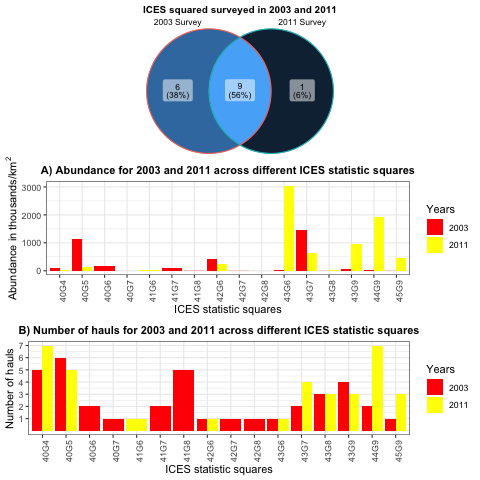

In [38]:
%%R
outer_grid <- ggarrange(
  plotlist = list(ices_hauling_by_year_plot, haul_year_barplot, ices_year_barplot),
  ncol = 1,
  nrow = 3
)
outer_grid

## 4.3) Map of hauls and abundances for 2003 and 2001 (QGIS) <a class="anchor" id="section_4_3"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

<img src='images/hauls_area.jpg'/> 

**Figure 2. Map of scientific hauls performed in 2003 and 2011 in the Central Baltic Sea.** Red dots represent the hauls performed in 2003; Yellow dots are associated to those in 2011.


<img src='images/abundance_ices_area.jpg'/>

**Figure 3. Map of relative abundances of sprats (Sprattus sprattus) at each scouted ICES squares in the Central Baltic Sea in 2003 and 2011.** Red dots and red numbers shows the relative abundances in thousands/km<sup>2</sup> of fish per ICES square in 2003; similarly yellow dots and numbers are associated to 2011. Notice that the red and yellow dots have been assigned different positions artificially when within the same ICES square to show the different year abundances clearly.

# 5) Python and R requirements <a class="anchor" id="chapter5"> </a><a href="#table_content"><img src='images/arrow-up-icon.png' width="16" height="16"/></a>

* **Python Requirements:** found in `requirements.txt` file
* **R Requirements:** libraries loaded at the beginning of `config.R` file